# Исследование сообщений из slack

Попробуем отыскать то самое множество любопытных инсайтов о жизни нашей когорты.

---

## Начало
<a id='inception' name='inception'></a>
Перестанем прокрастинировать и импортируем библиотеки (и всё такое)

In [ ]:
!pip install pymorphy2==0.9.1 -q

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os

import nltk
import pymorphy2
from string import punctuation as PUNCTUATION

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
STOPWORDS = nltk.corpus.stopwords.words('russian')

In [ ]:
MONTHS = mdates.MonthLocator()
DAYS = mdates.DayLocator()

pd.set_option(
    'display.float_format', lambda x: '%.3f' % x
)

sns.set(
    rc = {
        'figure.figsize': (16, 9),
        'figure.dpi': 80,
        'axes.grid': True,
        'axes.grid.axis': 'x',
        'axes.grid.which': 'both',
        'grid.alpha': .4,
        'xtick.minor.visible': True,
        },
    palette = 'colorblind',
    style = 'ticks'
)

In [ ]:
PATH = '/work/final_project/data/slack'

In [ ]:
TEAM = pd.read_csv(f'{PATH}/team.csv', squeeze=True)

In [ ]:
FILES = os.listdir(PATH)

In [ ]:
df = pd.DataFrame()

for file in FILES:
    if 'da_20' not in file: continue
    temp = pd.read_csv(f'{PATH}/{file}')
    for col in temp.select_dtypes('object'): temp[col] = temp[col].str.replace('ё', 'е')
    temp['channel'] = re.sub('(?:da_20_)|(?:[_\d]*.csv$)', '', file)
    temp = temp.query("real_name not in @TEAM")
    df = df.append(temp, ignore_index=True)

In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 0 to 2153
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   thread_ts  1998 non-null   float64
 1   ts         2154 non-null   float64
 2   user       2154 non-null   object 
 3   text       2144 non-null   object 
 4   reactions  946 non-null    object 
 5   real_name  2154 non-null   object 
 6   channel    2154 non-null   object 
dtypes: float64(2), object(5)
memory usage: 1.9 MB


Есть немного пропусков, два поля *thread_ts* и *ts*, которые одновременно являются и идентификатором сообщения, и временем создания. Обработаем это в следующем разделе.

---

## Предобработка
<a name='preprocessing' id='preprocessing'></a>
Почистим мусор, сделаем всякие штуки для удобства

Для начала приведём все строки в датасете к нижнему регистру:

In [ ]:
for col in df.select_dtypes('object'):
    df[col] = df[col].str.lower()

Теперь дадим нормальные идентификаторы тредам и сообщениям, и сделаем нормальное время создания:

In [ ]:
index = df['ts'].append(df['thread_ts'].dropna()).unique()
temp = pd.Series(
    index = index,
    data = range(len(index))
)

for col in ('thread_ts', 'ts'):
    df[re.sub('ts', 'id', col)] = df[col].replace(temp)
    df[col] = pd.to_datetime(df[col], unit='s')

Сразу отсортируем датасет по времени:

In [ ]:
df = df.sort_values('ts', ascending=False)

Посмотрим на пропуски:

In [ ]:
df.isna().mean()

thread_ts   0.072
ts          0.000
user        0.000
text        0.005
reactions   0.561
real_name   0.000
channel     0.000
thread_id   0.072
id          0.000
dtype: float64

Пропуск в поле с тредом говорит о том, что треда нет, а вот о чём говорят пропуски в поле с текстом - неизвестно. Посмотрим на них:

In [ ]:
df[df['text'].isna()]

,thread_ts,ts,user,text,reactions,real_name,channel,thread_id,id
1284,2021-04-17 11:41:32.223300096,2021-04-30 15:52:43.278300160,u01jr96sa4a,NaN,NaN,лидия маркевич,teamwork,1260.000,1284.000
1196,NaT,2021-03-18 10:33:54.002899968,u01e1nw6gl9,NaN,"[{'name': 'zany_face', 'users': ['u01jagddwdv'...",дарья новикова,teamwork,NaN,1196.000
1566,2021-01-30 15:15:27.064699904,2021-01-31 19:19:29.081199872,u01jrf7rqgk,NaN,NaN,елена науменко,info,1556.000,1566.000
1983,2021-01-26 12:38:06.098500096,2021-01-26 12:52:30.102899968,u01jn6nuznz,NaN,NaN,татьяна майстрова,projects,1978.000,1983.000
624,2021-01-25 18:47:29.255500032,2021-01-25 20:48:08.260000000,u01fzahgnd7,NaN,"[{'name': 'microphone', 'users': ['u01k3te8tgr...",валентин лапинский,teamwork,2168.000,624.000
1526,2021-01-18 06:02:19.248500224,2021-01-20 15:28:29.303299840,u01jagdfudd,NaN,NaN,инна тихонова,info,2195.000,1526.000
355,NaT,2021-01-17 08:59:49.476499968,u01fssdr3aq,NaN,NaN,шынгыс торез,teamwork,NaN,355.000
189,2021-01-14 22:21:04.252800000,2021-01-14 22:40:11.255399936,u01jxej1sds,NaN,"[{'name': '+1', 'users': ['u01jr96ug90', 'u01j...",иван тулин,teamwork,186.000,189.000
163,2021-01-14 17:49:22.185300224,2021-01-14 20:31:41.140800000,u01jn75dcud,NaN,"[{'name': 'heart_eyes', 'users': ['uv00h8nkb']...",татьяна писаревская,teamwork,78.000,163.000
1439,2021-01-14 16:56:08.062700032,2021-01-14 17:04:22.066499840,u01jjey5ydu,NaN,"[{'name': 'heavy_plus_sign', 'users': ['uv00h8...",виктор макаренко,info,2191.000,1439.000


Если найти эти сообщения в самом слаке, можно понять, что это сообщения с вложенным файлом без текста. Так же можно заметить, что время в датасете отстаёт на 3 часа, что тоже надо исправить:

In [ ]:
for col in df.select_dtypes('datetime64'):
    df[col] = df[col] + pd.Timedelta('3H')

Пропуски в *text* заполним флагом **attached_file**:

In [ ]:
df['text'] = df['text'].fillna('attached_file')

Пропуски в *thread_ts* и *thread_id* заполним соответствующими значениями из полей *ts* и *id*:

In [ ]:
for col in ('thread_ts', 'thread_id'):
    df[col] = df[col].fillna(df[re.sub('thread_', '', col)]).astype('int')

Теперь посмотрим на людей, которые зачем-то дублировали имя на латинице:

In [ ]:
temp = df.loc[df['real_name'].str.contains('[a-z]'), 'real_name'].unique()
temp

Обработаем эти имена:

In [ ]:
for name in temp:
    df.loc[df['real_name'] == name, 'real_name'] = re.sub('(?:\s*/[a-z\s]+$)|(?:^[a-z\s]+/\s*)', '', name)

In [ ]:
temp = df.loc[df['real_name'].str.contains('[a-z]'), 'real_name'].unique()
temp

array(['nikita bergman', 'ulad-khan', 'oлеся толмачева'], dtype=object)

Олесю трогать не будем (там просто первая английская, это не критично), остальных дропнем (у ulad-khan всего 2 сообщения, а nikita bergman - член команды практикума, ещё не забудем про наставника Глеба):

In [ ]:
df = df.query("real_name not in ['nikita bergman', 'ulad-khan', 'глеб михайлов']").reset_index(drop=True)

Если ещё какой мусор появится - порешаем по факту. 
<br>
А теперь - EDA.

---

## EDA
<a name='eda' id='eda'></a>
Найдём наконец те самые инсайты

Сначала посмотрим на активность пользователей.
<br>
Топ-10 пользователей по количеству сообщений:

In [ ]:
temp = (
    df
    .groupby('real_name')
    .agg({
        'text': 'count', 
        'channel': lambda x: f'{x.value_counts().index[0]} - {x.value_counts().iloc[0]}'
        })
    .sort_values('text', ascending=False)
    .head(10)
    )
temp

,text,channel
real_name,,
алексей орлов,78,teamwork - 69
александр смирнов,66,teamwork - 52
евгения овчинникова,66,teamwork - 57
мария грабова,62,teamwork - 24
лидия маркевич,42,teamwork - 26
елена науменко,36,info - 24
георгий дубовицкий,36,teamwork - 21
павел кузнецов,36,projects - 15
ирина василенко,35,teamwork - 22


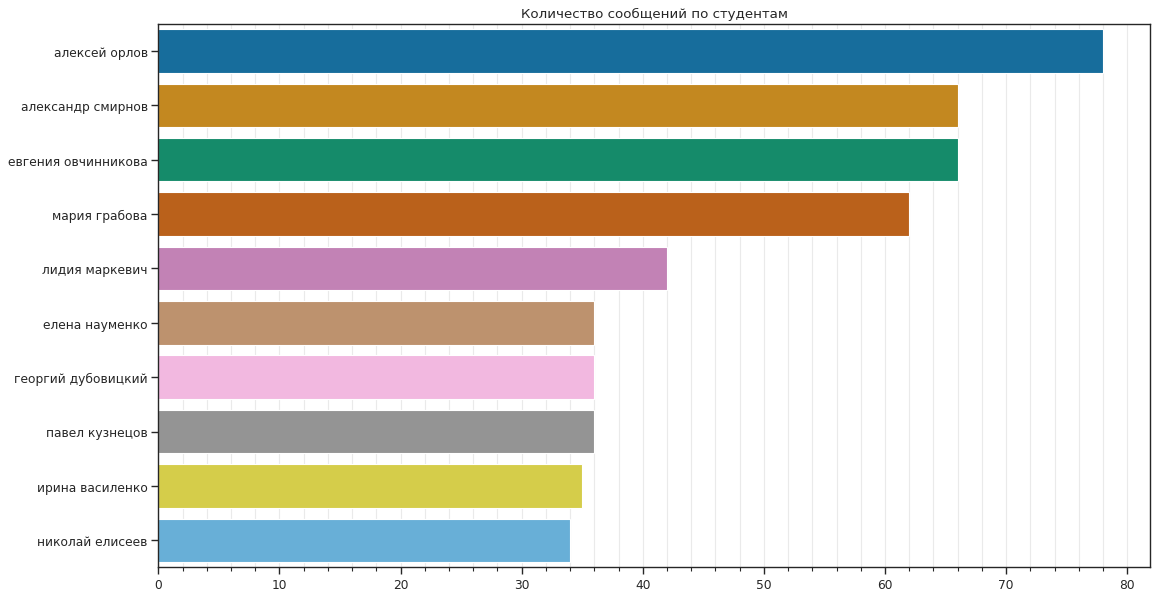

In [ ]:
sns.barplot(
    data = temp,
    x = 'text',
    y = temp.index,
    )
plt.title('Количество сообщений по студентам')
plt.xlabel('')
plt.ylabel('')
plt.show()

Видно, что лидирую по сообщениям я (внезапно), а самый популярный канал (**не** внезапно) - *teamwork* (других каналов тут и нет особо).
<br>
Посмотрим на тех, кто чаще других создавал треды:

In [ ]:
temp = df[df['id'] == df['thread_id']]['real_name'].value_counts().head(10)
temp

игорь малков          9
мария грабова         7
виктория опенько      7
александра пичуева    7
николай захаров       6
павел кузнецов        5
марина рябова         5
алексей орлов         5
екатерина шумилина    5
никита лопаткин       5
Name: real_name, dtype: int64

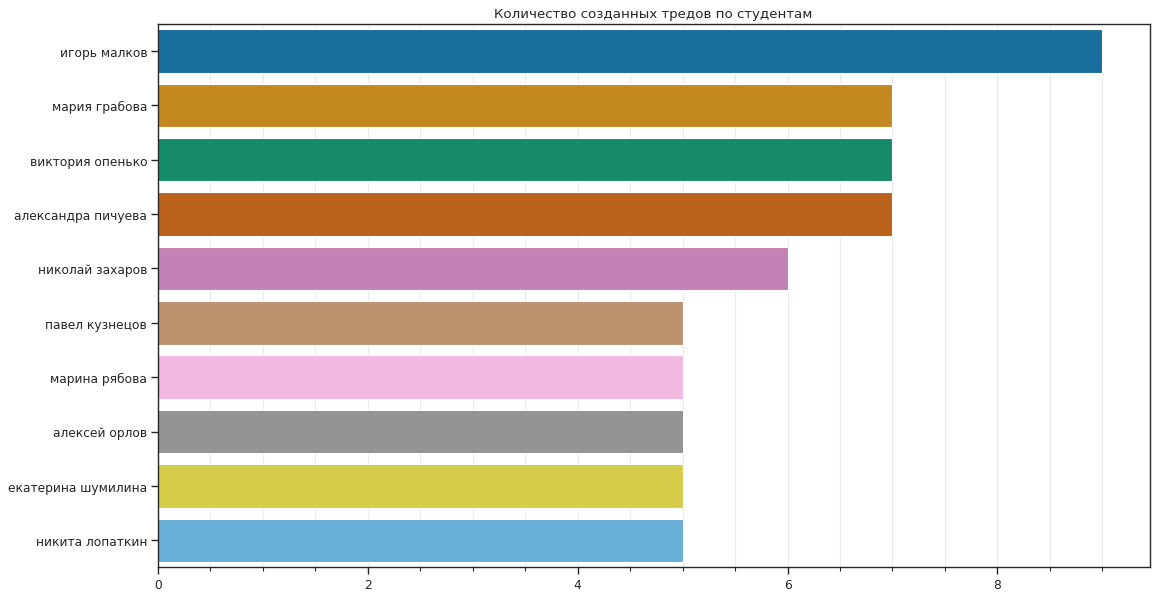

In [ ]:
sns.barplot(
    x = temp,
    y = temp.index,
    )
plt.title('Количество созданных тредов по студентам')
plt.xlabel('')
plt.ylabel('')
plt.show()

Взглянем дополнительно на пересечение этих двух множеств:

In [ ]:
len(temp.to_frame().join(df['real_name'].value_counts().head(10), rsuffix='_all', how='inner'))

3

В целом получается, что одни люди создают треды, а другие люди пишут под ними сообщения (одни - задают вопросы, вторые - отвечают?), а 5 человек пишут и там и там.
<br>
Вглянем так же на распределение сообщений и тредов по времени:

In [ ]:
df['create_thread'] = df['id'] == df['thread_id']

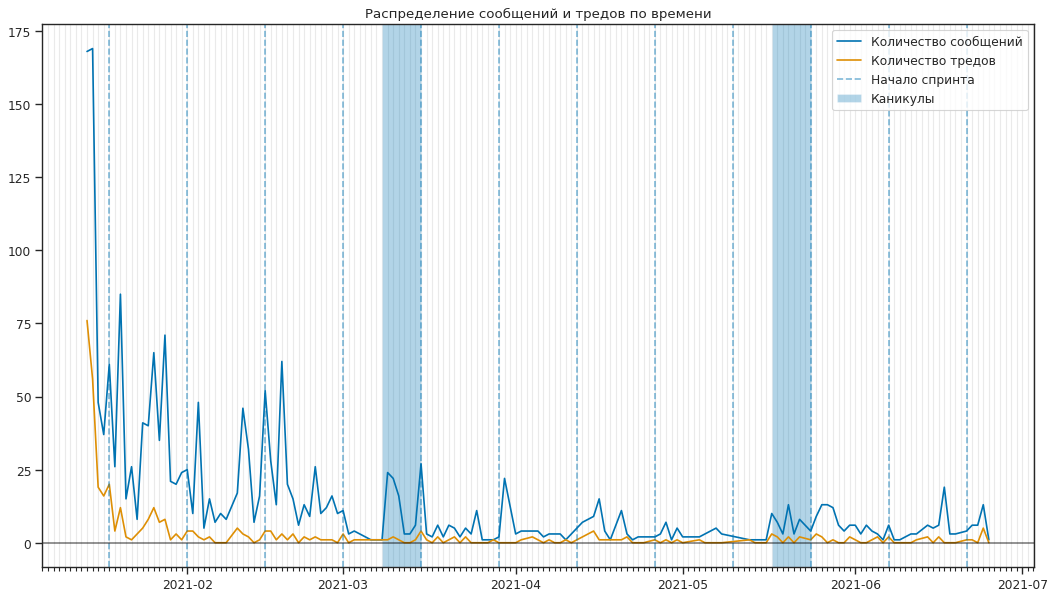

In [ ]:
temp = df.astype({'ts': 'datetime64[D]'}).groupby('ts').agg({'id': 'nunique', 'create_thread': 'sum'})

ax = sns.lineplot(
    data = temp,
    y = 'id',
    x = temp.index,
    label = 'Количество сообщений',
)

sns.lineplot(
    data = temp,
    y = 'create_thread',
    x = temp.index,
    label = 'Количество тредов',
    ax = ax
)

WEEKS = df['ts'].astype('datetime64[W]') + pd.Timedelta(4, 'D')
[
    ax.axvline(
        week, 
        alpha=.5, 
        ls='--', 
        label='Начало спринта' if i[0] == 1 else ''
        ) 
    for i, week in np.ndenumerate(WEEKS.unique()) if i[0]%2
]

for i, week in enumerate(['2021-03-08', '2021-05-17']):
    week = pd.to_datetime(week)
    ax.axvspan(
        week, 
        week + pd.Timedelta(7, 'D'), 
        alpha=.3, 
        label='Каникулы' if i==0 else ''
        )


ax.axhline(0, c='black', alpha=.5)
ax.xaxis.set_major_locator(MONTHS)
ax.xaxis.set_minor_locator(DAYS)
plt.title('Распределение сообщений и тредов по времени')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

Видна большая активность по тредам в первые две недели обучения (все знакомились и создавались всякие информационные треды) и активность по сообщениям первые 3 спринта. Так же активность увеличивалась во время каникул.
<br>
Посмотрим, какие каналы содержат больше всего тредов:

In [ ]:
df.groupby('channel')['thread_id'].nunique(dropna=False).sort_values(ascending=False)

channel
teamwork     373
info          73
exerciser     33
projects      26
Name: thread_id, dtype: int64

Так же посмотрим на распределение количества сообщений в тредах по каналам:

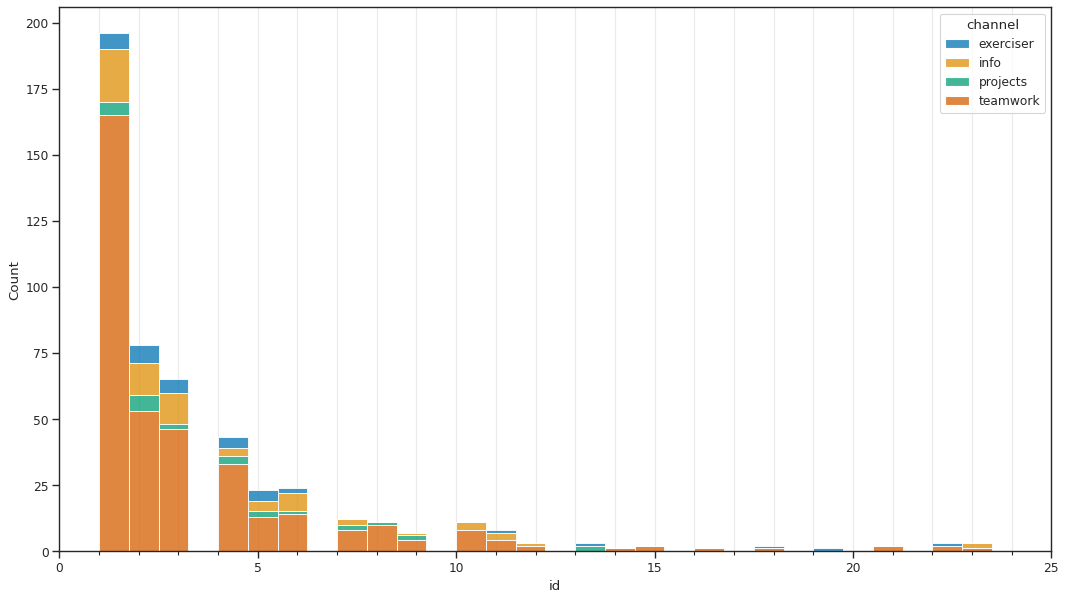

In [ ]:
temp = df.groupby(['channel', 'thread_id'])['id'].nunique().reset_index()
sns.histplot(
    data = temp,
    hue = 'channel',
    x = 'id',
    multiple = 'stack'
)

plt.xlim(0, 25)
plt.show()

В каком-то треде канала *teamwork* 80 сообщений. Посмотрим подробней:

In [ ]:
temp.sort_values('id', ascending=False).head()

,channel,thread_id,id
53,info,2191,79
65,info,2203,48
35,info,1647,35
364,teamwork,710,35
495,teamwork,2181,33


In [ ]:
df[df['thread_id'] == 2191].head()

,thread_ts,ts,user,text,reactions,real_name,channel,thread_id,id,create_thread
850,1610654168062700032,2021-02-13 23:09:21.283799808,u01fss7431a,"<@uv00h8nkb> привет, добавь, пожалуйста <mailt...",NaN,елена суханова,info,2191,1696.000,False
1434,1610654168062700032,2021-01-21 18:21:06.002299904,u01jxcpjw5a,"<@uv00h8nkb> добрый день, нет доступа по почте...","[{'name': 'eyes', 'users': ['uv00h8nkb'], 'cou...",екатерина лисовская,info,2191,1529.000,False
1475,1610654168062700032,2021-01-20 16:41:59.298799872,u01jxcsv9qc,"добрый день. нет доступа, выдайте, пожалуйста:...","[{'name': 'white_check_mark', 'users': ['uv00h...",екатерина шумилина,info,2191,1522.000,False
1557,1610654168062700032,2021-01-18 22:00:43.279699968,u01jafxbc07,"<@uv00h8nkb> привет, пошарь ноушен на эту почт...","[{'name': 'white_check_mark', 'users': ['uv00h...",ольга третьякова,info,2191,1521.000,False
1573,1610654168062700032,2021-01-18 16:37:39.269999872,u01jjeh79ln,добрый день. <@uv00h8nkb> пришлите пжта доступ...,NaN,елена уралец,info,2191,1519.000,False


Это тред с доступами для *Notion*, всё в порядке.
<br>
Посмотрим, как меняется количество сообщений в тредах во времени:

In [ ]:
df['hour'] = df['ts'].dt.hour

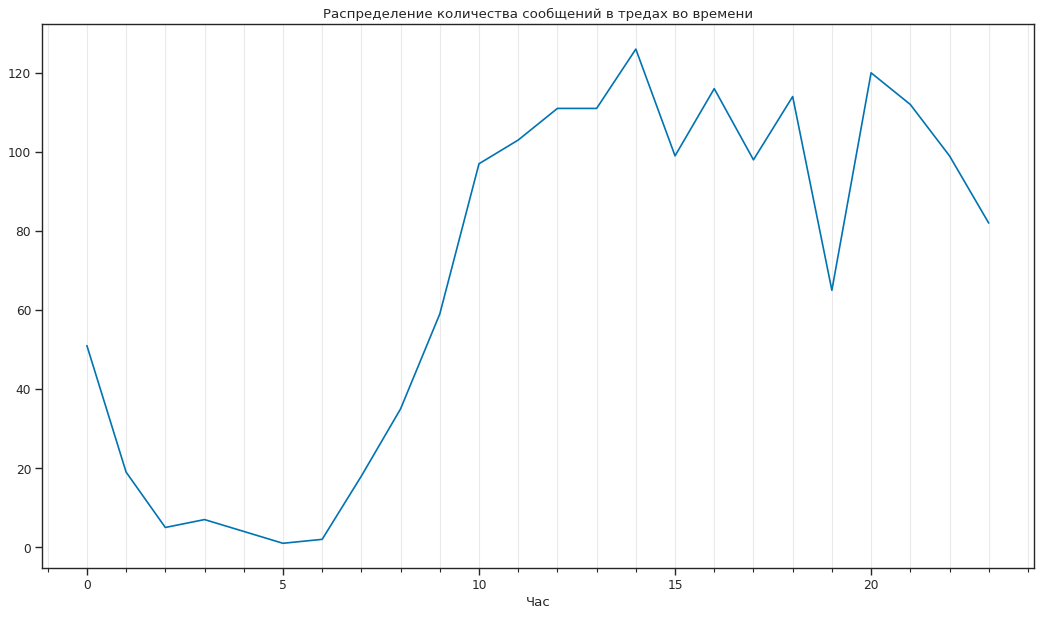

In [ ]:
temp = df[~df['create_thread']].groupby('hour')['thread_id'].count()
temp
sns.lineplot(
    x = temp.index,
    y = temp
)
plt.title('Распределение количества сообщений в тредах во времени')
plt.xlabel('Час')
plt.ylabel('')
plt.show()

Основная активность в тредах - вторая половина дня, самая большая - 8 вечера.
<br>
Найдём треды с максимальным количеством сообщений:

In [ ]:
df['thread_id'].value_counts().head(10)

2191    79
2203    48
1647    35
710     35
2181    33
456     32
1925    23
944     23
2211    23
2254    22
Name: thread_id, dtype: int64

И посмотрим на среднюю длину сообщения в каждом канале. Для начала нужно удалить лишние символы, слова и обращения: 

In [ ]:
STOPWORDS.append('attached_file')

def clean_text(text):
    """Возвращает строку, очищенную от знаков пунктуации и лишних слов."""
    text = re.split(' |:|\.|\(|\)|,|"|;|/|\n|\t|-|\?|\[|\]|!', text)
    text = ' '.join([word for word in text if word not in PUNCTUATION])
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    text = re.sub('<.+>', '', text)
    return text

In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
df['cnt_words'] = df['clean_text'].str.split().apply(lambda x: len(x) or 0)

In [ ]:
df[~df['create_thread']].groupby('channel')['cnt_words'].mean().sort_values(ascending=False)

channel
projects    15.685
exerciser   15.114
teamwork    13.950
info         9.589
Name: cnt_words, dtype: float64

Самые длинные сообщения в каналах *projects* и *exerciser*.
<br>
Посмотрим, кто писал самые длинные сообщения:

In [ ]:
df[~df['create_thread']].groupby('real_name').agg({'cnt_words': 'mean', 'id': 'nunique'}).sort_values('cnt_words', ascending=False).head(10)

,cnt_words,id
real_name,,
лера ершова,71.500,2
аня слепнева,66.500,2
сандра аверьянова,59.000,3
анастасия андрюхина,41.000,3
владислав злоцкий,40.963,27
денис григорьев,34.200,5
ярослава скрабовская,34.000,2
денис богомолов,33.000,8
денис седура,32.000,2


Самые длинные сообщения в основном писали те, кто писал редко.
<br>
Посмотрим количество соощений по каналам:

In [ ]:
df.groupby('channel')['id'].nunique().sort_values(ascending=False)

channel
teamwork     1297
info          460
exerciser     166
projects      117
Name: id, dtype: int64

Больше всех сообщений в *teamwork*.
<br>
Посмотрим на среднее количество сообщений на тред:

In [ ]:
df[~df['create_thread']].groupby(['channel', 'thread_id'])['id'].nunique().mean(level=0).sort_values(ascending=False)

channel
info        6.408
exerciser   5.321
teamwork    4.415
projects    4.381
Name: id, dtype: float64

Больше всех сообщений в канале *info*.
<br>
И, наконец, посмотрим на динамику создания сообщений в каждом из каналов:

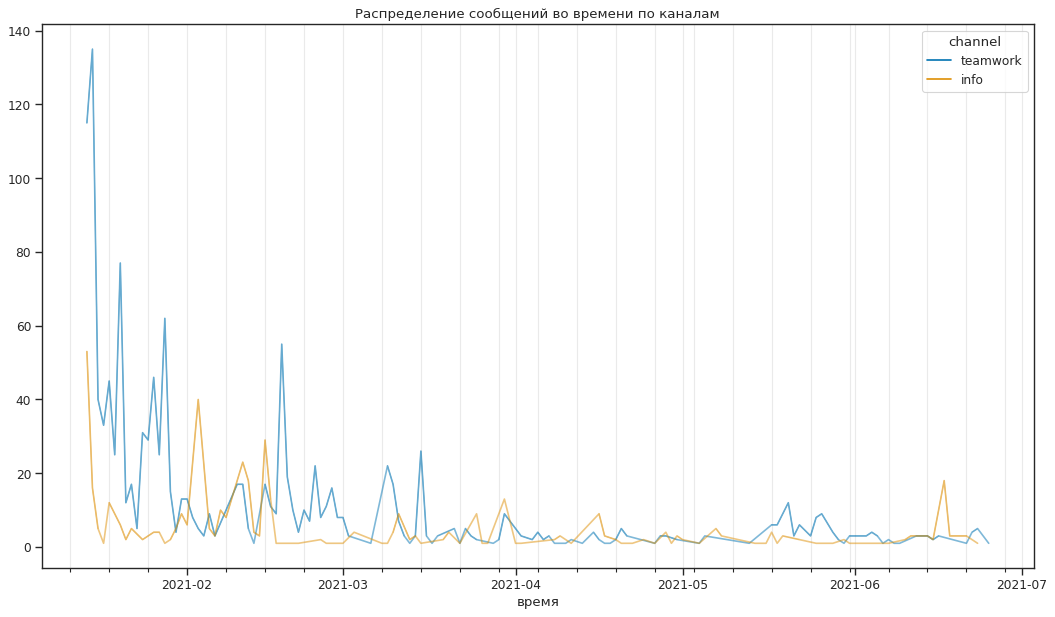

In [ ]:
sns.lineplot(
    data = df.astype({'ts': 'datetime64[D]'}).query("channel in ['teamwork', 'info']"),
    x = 'ts',
    y = 'id',
    estimator = len,
    hue = 'channel',
    alpha = .5
)

plt.title('Распределение сообщений во времени по каналам')
plt.xlabel('время')
plt.ylabel('')
plt.show()

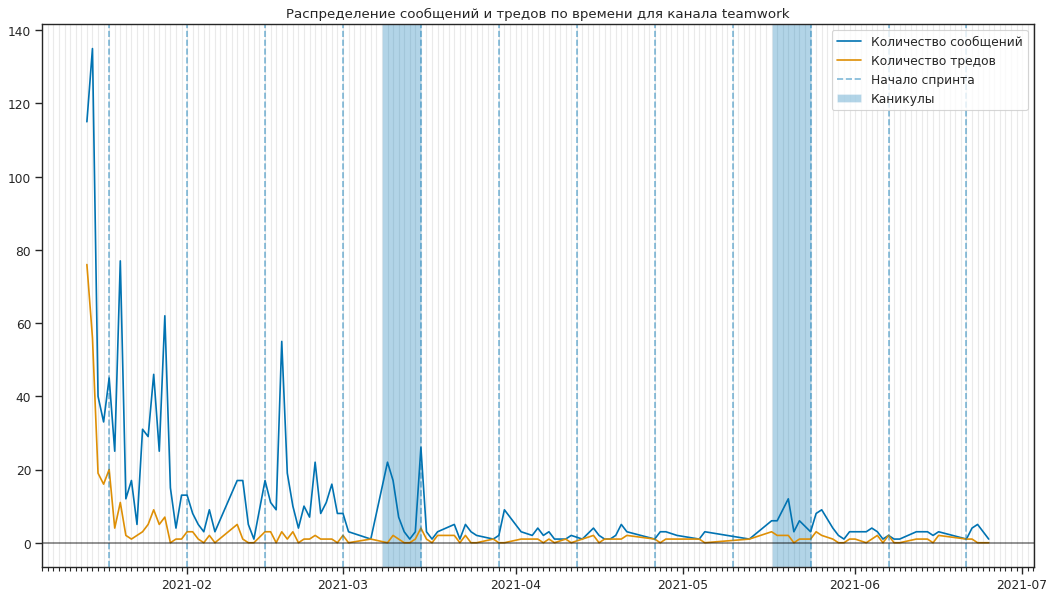

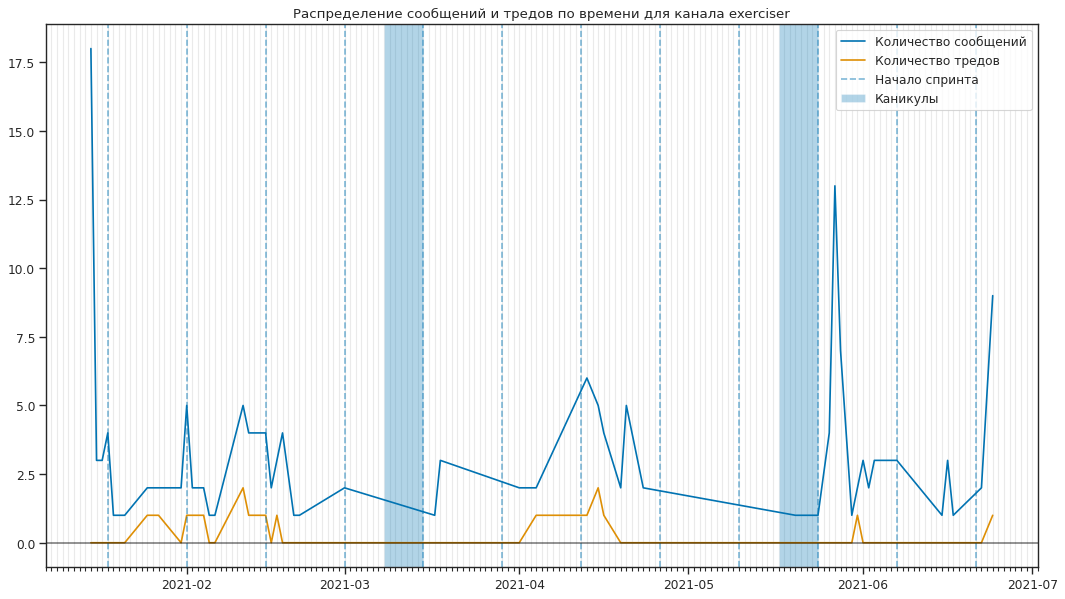

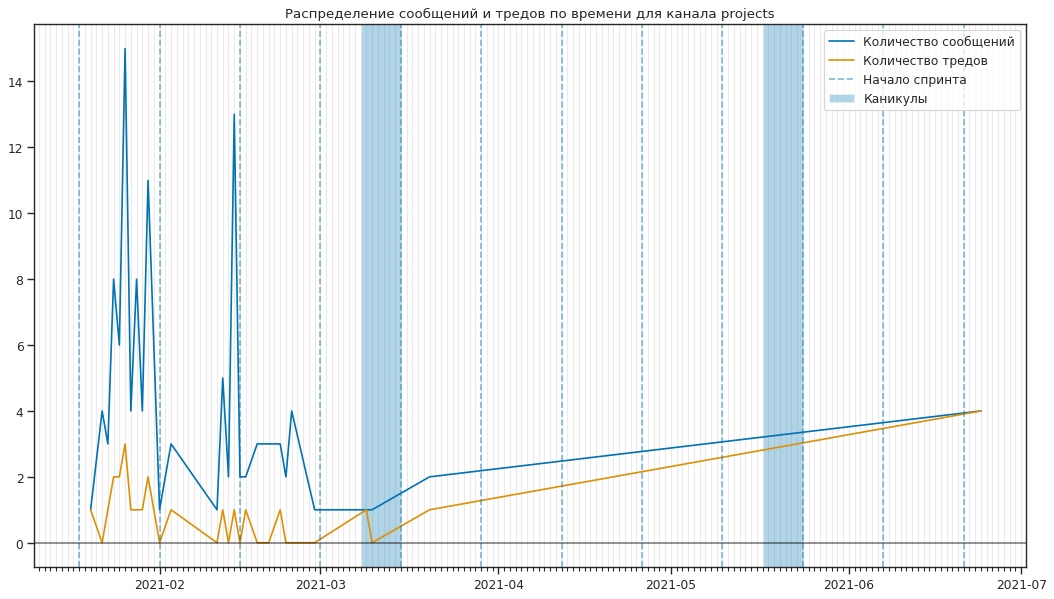

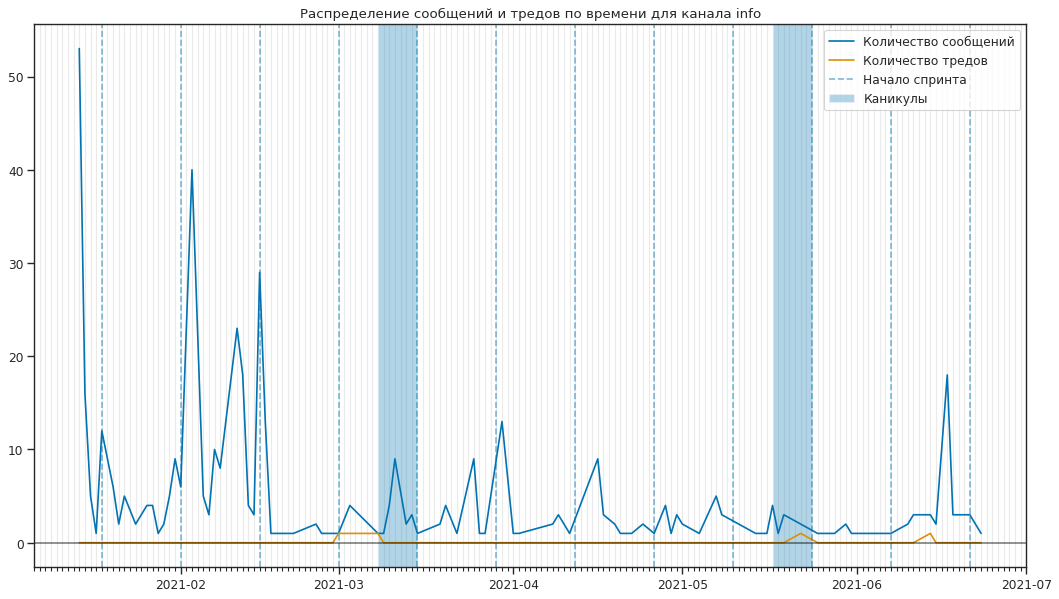

In [ ]:
for channel in df['channel'].unique():    
    
    temp = df.query("channel == @channel").astype({'ts': 'datetime64[D]'}).groupby('ts').agg({'id': 'nunique', 'create_thread': 'sum'})

    ax = sns.lineplot(
        data = temp,
        y = 'id',
        x = temp.index,
        label = 'Количество сообщений',
    )

    sns.lineplot(
        data = temp,
        y = 'create_thread',
        x = temp.index,
        label = 'Количество тредов',
        ax = ax
    )

    WEEKS = df['ts'].astype('datetime64[W]') + pd.Timedelta(4, 'D')
    [
        ax.axvline(
            week, 
            alpha=.5, 
            ls='--', 
            label='Начало спринта' if i[0] == 1 else ''
            ) 
        for i, week in np.ndenumerate(WEEKS.unique()) if i[0]%2
    ]

    for i, week in enumerate(['2021-03-08', '2021-05-17']):
        week = pd.to_datetime(week)
        ax.axvspan(
            week, 
            week + pd.Timedelta(7, 'D'), 
            alpha=.3, 
            label='Каникулы' if i==0 else ''
            )


    ax.axhline(0, c='black', alpha=.5)
    ax.xaxis.set_major_locator(MONTHS)
    ax.xaxis.set_minor_locator(DAYS)
    plt.title(f'Распределение сообщений и тредов по времени для канала {channel}')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()
    plt.show()

По каналам *projects* и *exerciser* нет особого смысла писать выводы - видно только начальную активность со знакомствами и вопросами на общие темы, а основная активность не выгружена. Для канала *teamwork* активность совпадает с уже описанной по общему графику - высокая активность в самом начале (все знакомились) и чуть возросшая во время каникул. Канал *info* выглядит примерно так же, при этом имеет хоть какую-то активность на протяжении всего курса (постоянные объявления от команды практикума с комментариями под ними).

## Выводы
<a id='conclusions' name='conclusions'></a>
Попробуем написать что-нибудь умное

Единственный обнаруженный любопытный инсайт - то, что я написал больше всех сообщений, остальное всё скучное и вообще проект неполноценен без полноценных данных.
<br>
Другие обнаруженные факты - высокая активность по всем фронтам в начале обучения и возрастающая активность в каникулы

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73c6fdc9-2380-4d92-b495-95da9dd36eb1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>